# Synthesizer constant-by-part trajectories

Constant-by-part trajectories are trajectories for which the value are constant for an arbitrary number of timesteps before changing the value.   
A typical example would be a sensor that measures a value every few seconds but the quantity measures is expected to move every minute or so.    
Another example could be the director rate of central banks which are reported periodically but might not change for each report.

This behavior is in general hard to replicate for any generative model. However in this notebook, we present a solution to mitigate this problem and help the synthetic data to respect the constant-by-part behavior.    
We will take the example of the Unemployment rate associated to the region of a given store. The Unemployment rate is reported less frequently than the sampling rate, such that it is constant by part.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata.synthesizers.timeseries.model import TimeSeriesSynthesizer
from ydata.metadata import Metadata
from ydata.dataset import Dataset
from ydata.dataset.dataset_type import DatasetType

In [16]:
original_df = pd.read_csv('Walmart.csv')
original_df = original_df[original_df.Store == 1]

In [17]:
original_df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
138,1,28-09-2012,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,05-10-2012,1670785.97,0,68.55,3.617,223.181477,6.573
140,1,12-10-2012,1573072.81,0,62.99,3.601,223.381296,6.573
141,1,19-10-2012,1508068.77,0,67.97,3.594,223.425723,6.573


We can observe that the `Unemployment` trajectory is constant by part: it remains constant for approximately 13 steps before a value change.    
Note that the number of steps between value changes is not constant and varies between 8 and 14.

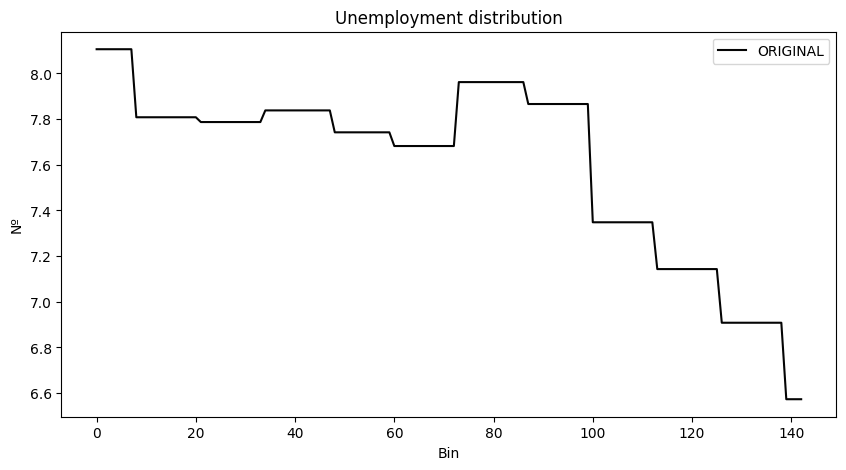

In [5]:
plt.figure(figsize=[10, 5])
plt.title(f"Unemployment distribution")
original_df['Unemployment'].plot(color="#040404", label="ORIGINAL")
plt.xlabel("Bin")
plt.ylabel("Nº")
plt.legend()

We define two functions:
- `find_change_points` which calculates a mask on the original data to indicate where the steps are located. It does not use the values, only indicate the change points.
- `apply_change_points` which uses the previously computed change points on the synthetic data and recompute the trajectory to respect the constant-by-part behavior of the original data.

In [6]:
def find_change_points(df: pd.DataFrame, columns: list[str]) -> dict[str, pd.Series]:
    markers = {}
    for c in columns:
        derivative = original_df[c] - original_df[c].shift(1)
        derivative[0] = 0
        markers[c] = (derivative != 0).astype(int)
    return markers

In [7]:
def apply_change_points(df: pd.DataFrame, markers: dict[str, pd.Series]) -> pd.DataFrame:
    for c, m in markers.items():
        ratio = df.shape[0] // m.shape[0]
        mask = pd.concat([m] * ratio).reset_index(drop=True)
        zero = df.loc[0, c]
        df.loc[df[mask == 0].index, c] = np.NaN
        df.loc[0, c] = zero
        df[c] = df[c].ffill()
    return df

We compute the change points on the original data for the column `Unemployment`.

In [8]:
markers = find_change_points(original_df, ['Unemployment'])

We train a synthesizer as we would do for any other dataset, regardless of the columns with a constant-by-part behavior.

In [9]:
original = Dataset(original_df)
original.astype('Date', 'datetime', '%d-%m-%Y')
metadata = Metadata()
dataset_attrs = {
    "sortbykey": "Date"
}
m = metadata(original, dataset_attrs, dataset_type=DatasetType.TIMESERIES)

synthesizer = TimeSeriesSynthesizer()
synthesizer.fit(original, metadata=m)

[########################################] | 100% Completed | 102.23 ms
[########################################] | 100% Completed | 102.24 ms
[########################################] | 100% Completed | 101.22 ms
[########################################] | 100% Completed | 101.32 ms
[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 102.18 ms
[########################################] | 100% Completed | 103.70 ms
[########################################] | 100% Completed | 131.21 ms
[########################################] | 100% Completed | 105.90 ms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 103.48 ms
[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 101.91 ms
[########################################] | 100% Completed | 10

We synthesize a few trajectories from the training 

In [10]:
sample = synthesizer.sample(n_entities=4)
sample_df = sample.to_pandas()

INFO: 2024-02-28 10:50:29,323 [SYNTHESIZER] - Start generating model samples.
INFO: 2024-02-28 10:50:29,462 [SYNTHESIZER] - Start generating model samples.
INFO: 2024-02-28 10:50:29,708 [SYNTHESIZER] - Start generating model samples.
INFO: 2024-02-28 10:50:29,950 [SYNTHESIZER] - Start generating model samples.


In [11]:
sample_df = sample_df.sort_values(by=['entity', 'Date'], ignore_index=True)

We apply the change points and reconstruct the trajectory automatically.

In [12]:
sample_df = apply_change_points(sample_df, markers)

The trajectories are different from the original and respect the constant-by-part behavior.

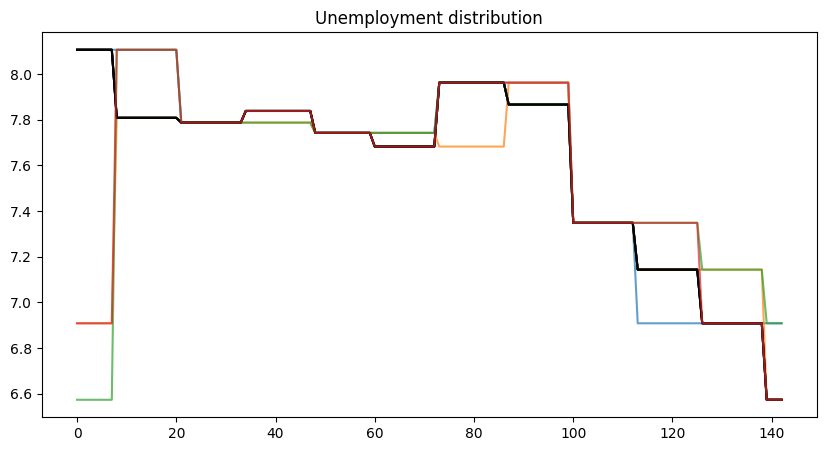

In [13]:
plt.figure(figsize=[10, 5])
plt.title(f"Unemployment distribution")
for i in range(4):
    original_df['Unemployment'].plot(color="#040404", label="ORIGINAL")
    sample_df[sample_df['entity'] == f'entity_{i}'].reset_index()['Unemployment'].plot(alpha=0.7)

The overall value distribution still respect the original distribution.

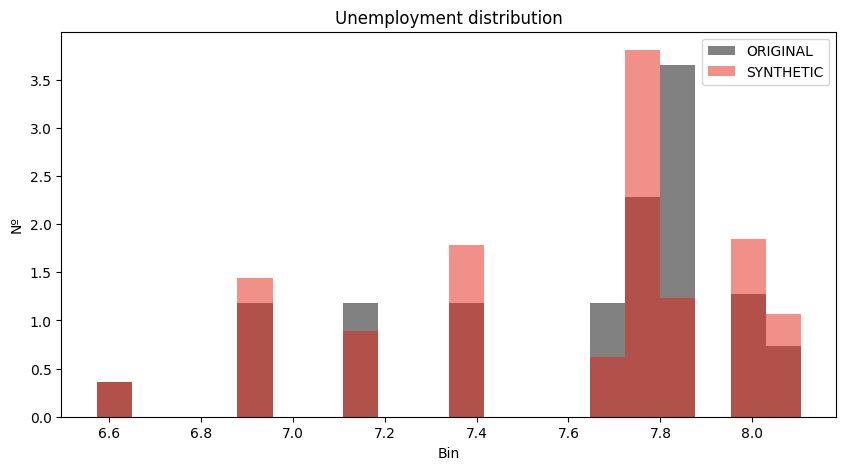

In [14]:
plt.figure(figsize=[10, 5])
plt.title(f"Unemployment distribution")
original_df['Unemployment'].hist(color="#040404", label="ORIGINAL", grid=False, bins=20, alpha=0.5, density=True)
sample_df['Unemployment'].hist(color="#E32212", label="SYNTHETIC", grid=False, bins=20, alpha=0.5, density=True)
plt.xlabel("Bin")
plt.ylabel("Nº")
plt.legend()
